In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay, PrecisionRecallDisplay
)
import time
from scipy.stats import uniform

In [26]:
#read in terrorism dataset
terrorism = pd.read_csv(r"C:\Users\ryanc\Downloads\gtd_full.csv")

#output the first five rows to see if the file read in correctly- IT DID!
terrorism.head()

#only include those terrorist attacks that met the three criteria listed in the codebook
mask = (terrorism['crit1'] == 1) & (terrorism['crit3'] == 1) & (terrorism['crit3'] == 1)
terrorism = terrorism[mask].drop(columns = ['crit1', 'crit2', 'crit3'])
terrorism.head()

C:\Users\ryanc\AppData\Local\Temp\ipykernel_14436\3779397254.py:2: DtypeWarning: Columns (4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  terrorism = pd.read_csv(r"C:\Users\ryanc\Downloads\gtd_full.csv")


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Preparing the dataset...
Dataset split completed.
Subset size: 50000 rows

--- Starting Randomized Search for Polynomial Kernel ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Randomized Search for Polynomial Kernel completed in 34304.35 seconds
Best Parameters (Polynomial Kernel): {'svc__C': 58.08371216819946, 'svc__degree': 5}
Best Cross-Validation Accuracy: 0.54
Optimizing threshold using logistic regression...
Optimal Threshold (Polynomial Kernel): 0.43

Performance at Logistic Regression-Optimized Threshold:
Precision: 0.4555
Recall: 0.9811
F1 Score: 0.6221


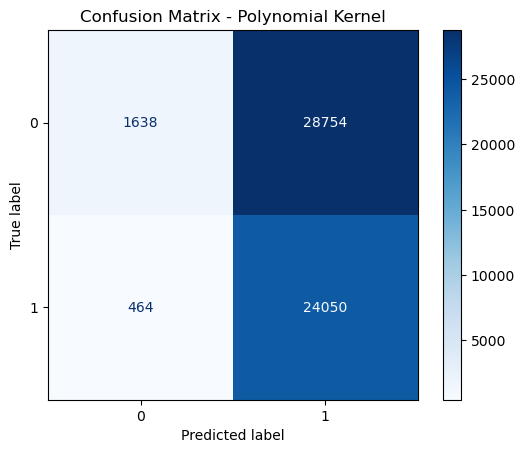

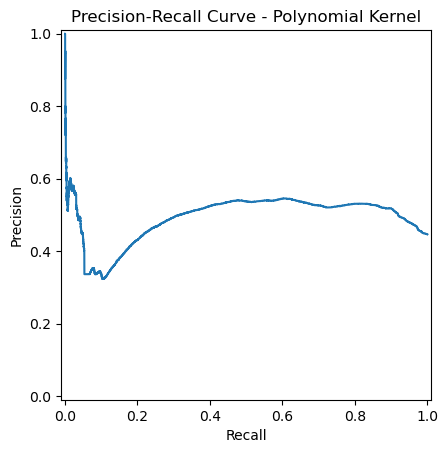

In [28]:
# Polynomial Kernel Code
# Dataset Preparation
print("Preparing the dataset...")
numerical_columns = ['nkillter', 'nwound', 'iyear', 'suicide', 'extended', 'success']
categorical_columns = ['attacktype1_txt', 'targtype1_txt', 'weaptype1_txt', 'region_txt']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_columns)
    ]
)

# Create the target variable
terrorism['civilian_deaths'] = terrorism['nkill'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into features (X) and target (y)
X = terrorism[numerical_columns + categorical_columns]
y = terrorism['civilian_deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Dataset split completed.")

# Use a Subset of the Training Set
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42, stratify=y_train
)
print(f"Subset size: {X_train_subset.shape[0]} rows")

# Polynomial Kernel Pipeline
pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', SVC(kernel='poly', probability=True, random_state=42, max_iter=5000))
])

# Randomized Search
param_distributions_poly = {
    'svc__C': uniform(loc=0.0001, scale=1000),
    'svc__degree': [2, 3, 4, 5]  # Degree of polynomial kernel
}

random_search_poly = RandomizedSearchCV(
    pipeline_poly, param_distributions=param_distributions_poly,
    n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, verbose=3, random_state=42
)

print("\n--- Starting Randomized Search for Polynomial Kernel ---")
start_time = time.time()
random_search_poly.fit(X_train_subset, y_train_subset)
end_time = time.time()
print(f"Randomized Search for Polynomial Kernel completed in {end_time - start_time:.2f} seconds")
print(f"Best Parameters (Polynomial Kernel): {random_search_poly.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search_poly.best_score_:.2f}")

# Train Best Polynomial Model
best_poly_model = random_search_poly.best_estimator_
y_pred_proba = best_poly_model.predict_proba(X_test)[:, 1]

# Logistic Regression for Threshold Optimization
print("Optimizing threshold using logistic regression...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(y_pred_proba.reshape(-1, 1), y_test)

# Predict probabilities for the optimal threshold
thresholds = np.linspace(0.1, 0.99, 50)
precision_scores, recall_scores, f1_scores = [], [], []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Polynomial Kernel): {optimal_threshold:.2f}")

# Evaluate at Optimal Threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)

print("\nPerformance at Logistic Regression-Optimized Threshold:")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1:.4f}")

# Confusion Matrix
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=[0, 1])
disp_optimal.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Polynomial Kernel")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve - Polynomial Kernel")
plt.show()

Preparing the dataset...
Dataset split completed.
Subset size: 50000 rows

--- Starting Randomized Search for Polynomial Kernel ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Randomized Search for Polynomial Kernel completed in 47417.91 seconds
Best Parameters (Polynomial Kernel): {'svc__C': 6.515159298527951, 'svc__degree': 2}
Best Cross-Validation Accuracy: 0.77
Optimizing threshold using logistic regression...
Optimal Threshold (Polynomial Kernel): 0.64

Performance at Logistic Regression-Optimized Threshold:
Precision: 0.7075
Recall: 0.7290
F1 Score: 0.7181


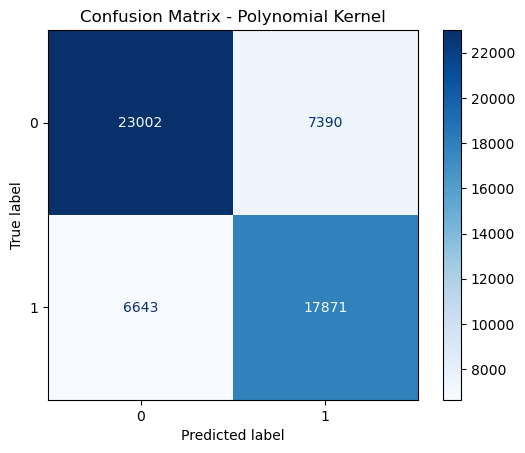

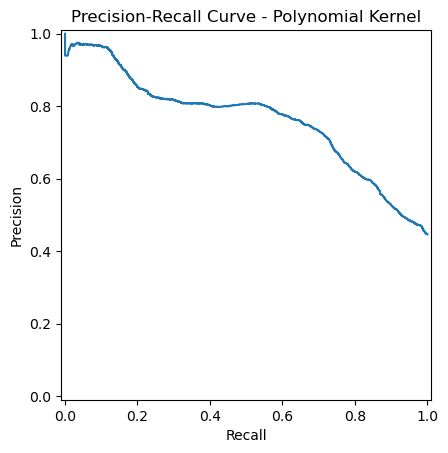

In [31]:
# Dataset Preparation
print("Preparing the dataset...")
numerical_columns = ['nkillter', 'nwound', 'iyear', 'suicide', 'extended', 'success']
categorical_columns = ['attacktype1_txt', 'targtype1_txt', 'weaptype1_txt', 'region_txt']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_columns)
    ]
)

# Create the target variable
terrorism['civilian_deaths'] = terrorism['nkill'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into features (X) and target (y)
X = terrorism[numerical_columns + categorical_columns]
y = terrorism['civilian_deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Dataset split completed.")

# Use a Subset of the Training Set
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42, stratify=y_train
)
print(f"Subset size: {X_train_subset.shape[0]} rows")

# Polynomial Kernel Pipeline
pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', SVC(kernel='poly', probability=True, random_state=42, max_iter=20000))  # Increased max_iter
])

# Randomized Search
param_distributions_poly = {
    'svc__C': uniform(loc=0.01, scale=100),  # Moderate C range
    'svc__degree': [2, 3, 4]  # Limited polynomial degrees
}

random_search_poly = RandomizedSearchCV(
    pipeline_poly, param_distributions=param_distributions_poly,
    n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, verbose=3, random_state=42
)

print("\n--- Starting Randomized Search for Polynomial Kernel ---")
start_time = time.time()
random_search_poly.fit(X_train_subset, y_train_subset)
end_time = time.time()
print(f"Randomized Search for Polynomial Kernel completed in {end_time - start_time:.2f} seconds")
print(f"Best Parameters (Polynomial Kernel): {random_search_poly.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search_poly.best_score_:.2f}")

# Train Best Polynomial Model
best_poly_model = random_search_poly.best_estimator_
y_pred_proba = best_poly_model.predict_proba(X_test)[:, 1]

# Logistic Regression for Threshold Optimization
print("Optimizing threshold using logistic regression...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(y_pred_proba.reshape(-1, 1), y_test)

# Predict probabilities for the optimal threshold
thresholds = np.linspace(0.5, 0.99, 50)
precision_scores, recall_scores, f1_scores = [], [], []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Polynomial Kernel): {optimal_threshold:.2f}")

# Evaluate at Optimal Threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)

print("\nPerformance at Logistic Regression-Optimized Threshold:")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1:.4f}")

# Confusion Matrix
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=[0, 1])
disp_optimal.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Polynomial Kernel")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve - Polynomial Kernel")
plt.show()